In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
# fetch the training file
file_path_20_percent = '../content/sample_data/KDDTrain+_20Percent.txt'
file_path_full_training_set = '../content/sample_data/KDDTrain+.txt'
file_path_test = '../content/sample_data/KDDTest+.txt'

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [4]:
#data set doesn't include column names, add them.
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [5]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


In [6]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
Sybil = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','U2R','Sybil']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in U2R:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in Sybil:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0

    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


In [7]:
# attack vs MCS protocols
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


In [8]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)

    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}

    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)

    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list):

        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)

        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])

    return axs

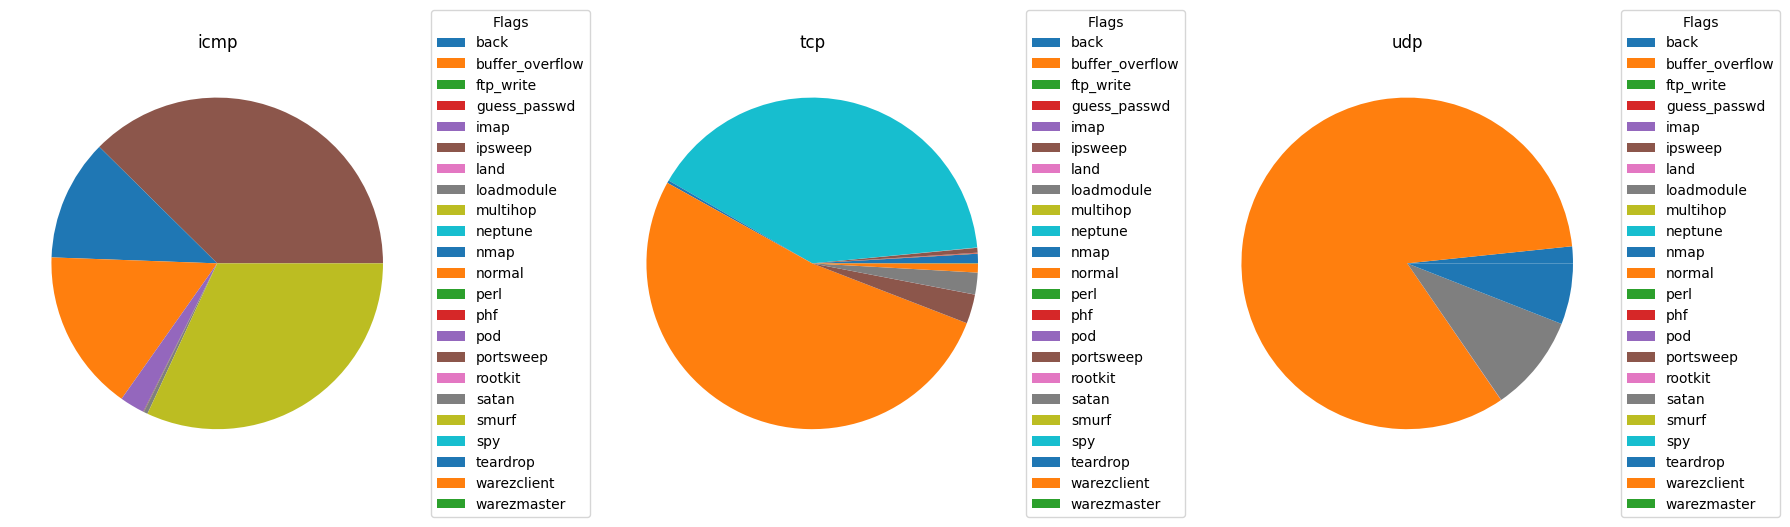

In [9]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

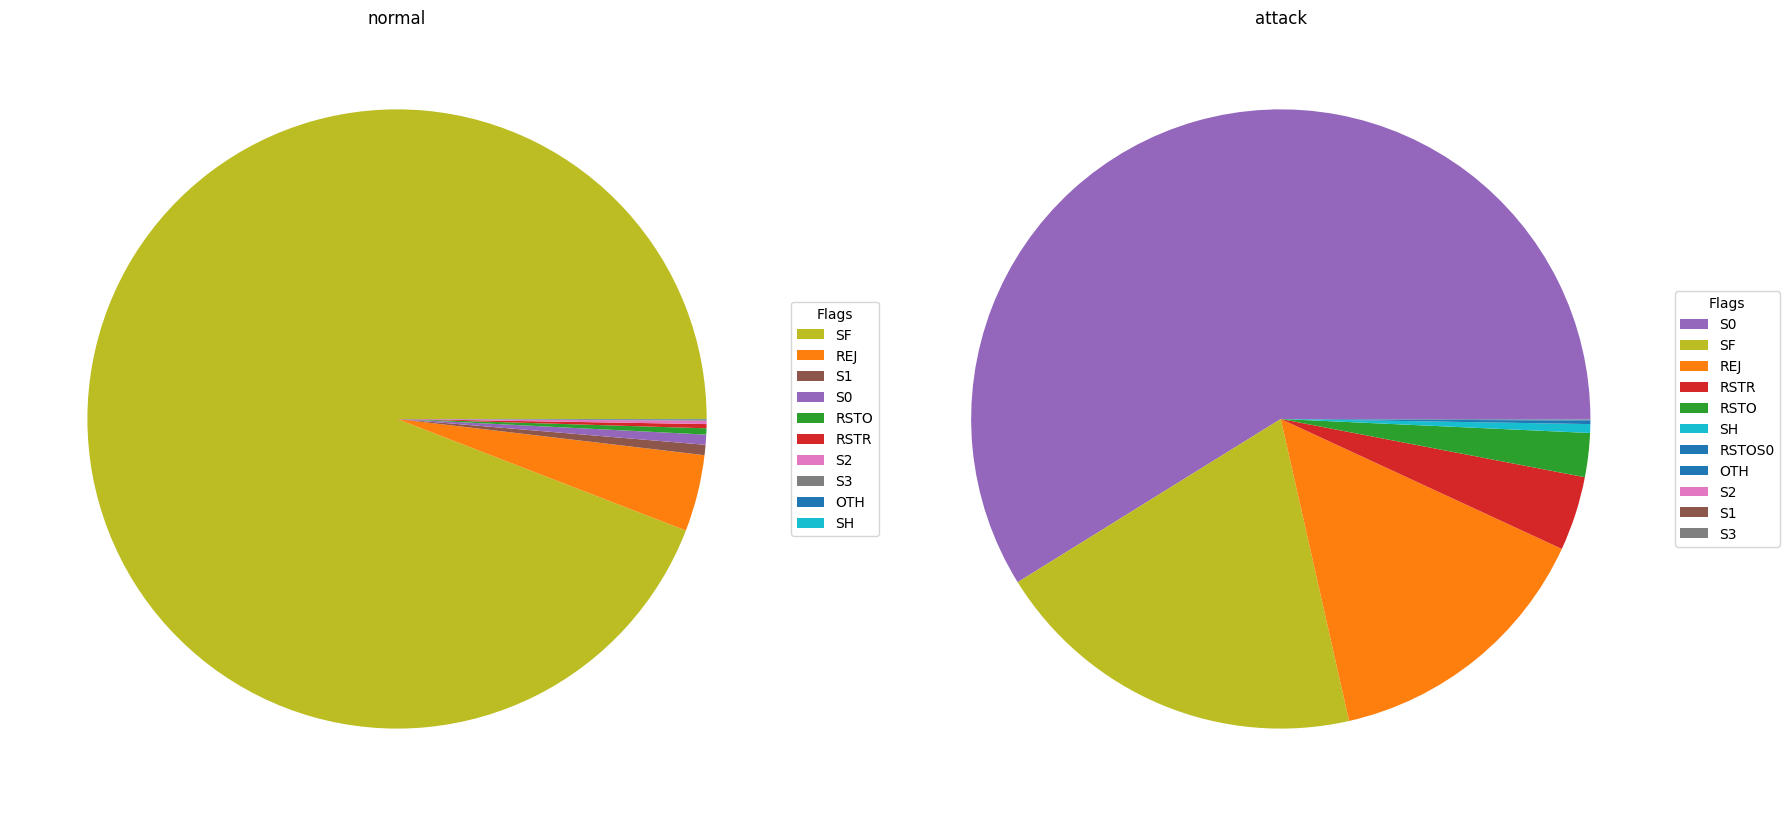

In [10]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])
plt.show()

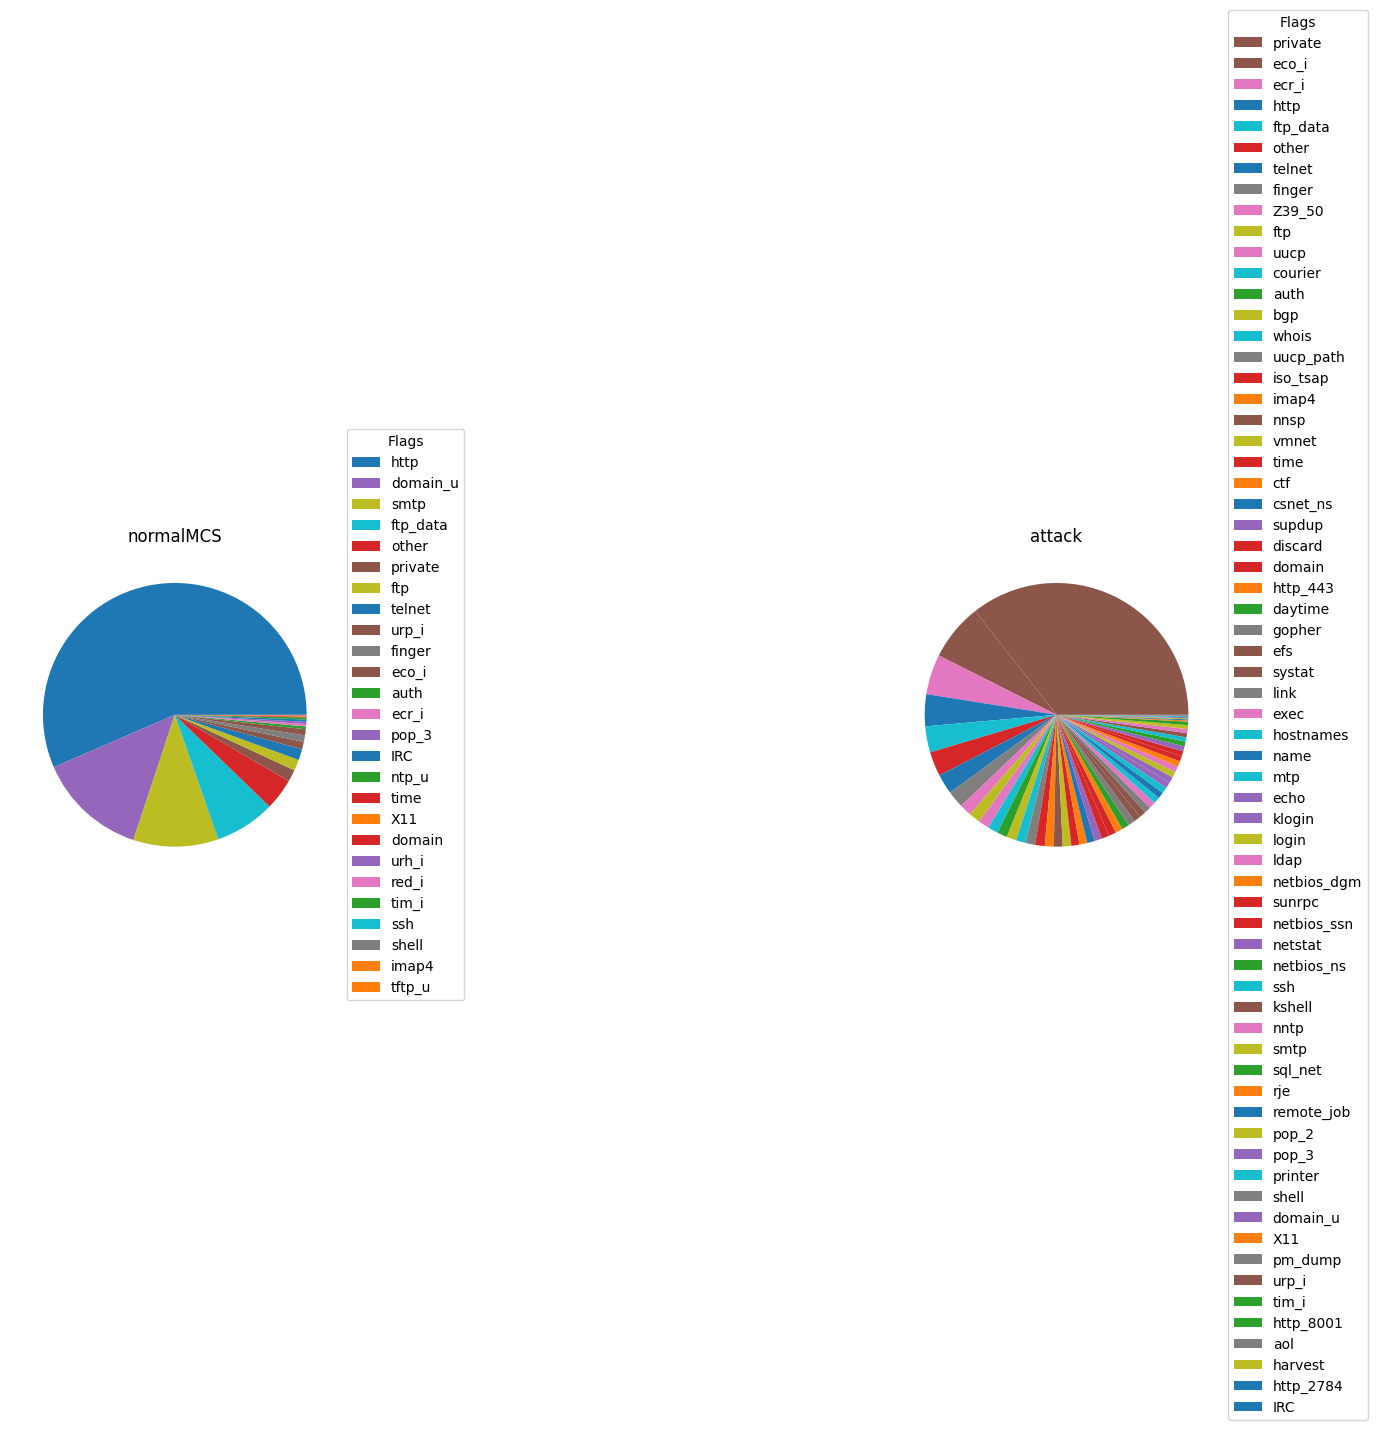

In [11]:
# get a series with the count of each service for attack and normal MCS
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normalMCS','attack'])
plt.show()

In [12]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])


In [13]:
# create our target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

In [14]:
# Cell 4 (Updated): Save the trained model locally after training
from sklearn.ensemble import RandomForestClassifier
import joblib
# Cell 4 (Updated): Save the trained model locally after training
from sklearn.ensemble import RandomForestClassifier
import joblib
import pandas as pd

# Model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)

# Save the trained model to a file
model_path = 'binary_model.pkl'
joblib.dump(binary_model, model_path)
print(f"Model saved to {model_path}")

# Predict and evaluate
binary_predictions = binary_model.predict(binary_val_X)

# Convert numeric predictions to labels
binary_prediction_labels = ["Attack" if pred == 1 else "No Attack" for pred in binary_predictions]

# Add predictions as a new column to the validation dataset
binary_val_dataset = binary_val_X.copy()
binary_val_dataset['Prediction'] = binary_prediction_labels

# Print the dataset with predictions
print("Validation Dataset with Predictions:")
print(binary_val_dataset.head())

# Calculate and display base accuracy
base_rf_score = accuracy_score(binary_predictions, binary_val_y)
base_rf_score

# ---- Add this as a new cell ----

# Cell: Load the model and predict
# Load the model from the file
loaded_model = joblib.load(model_path)
print("Model loaded successfully.")

# Make predictions on a new dataset (example: test_set)
new_predictions = loaded_model.predict(test_set)

# Convert numeric predictions to labels
new_prediction_labels = ["Attack" if pred == 1 else "No Attack" for pred in new_predictions]

# Add predictions as a new column to the test dataset
test_dataset_with_predictions = test_set.copy()
test_dataset_with_predictions['Prediction'] = new_prediction_labels

# Print the test dataset with predictions
print("Test Dataset with Predictions:")
print(test_dataset_with_predictions.head())

# Output predictions
print("Predictions (Labels):", new_prediction_labels)

# ---- Separate prediction code ----

# Separate function for predictions
def predict_with_labels_and_add_column(model_path, dataset):
    # Load the model
    loaded_model = joblib.load(model_path)
    print("Model loaded successfully.")

    # Make predictions
    predictions = loaded_model.predict(dataset)

    # Convert numeric predictions to labels
    prediction_labels = ["Attack" if pred == 1 else "No Attack" for pred in predictions]

    # Add predictions as a new column to the dataset
    dataset_with_predictions = dataset.copy()
    dataset_with_predictions['Prediction'] = prediction_labels

    return dataset_with_predictions

# Example usage
# test_dataset_with_predictions = predict_with_labels_and_add_column('binary_model.pkl', test_set)
# print("Dataset with Predictions:")
# print(test_dataset_with_predictions.head())


Model saved to binary_model.pkl
Validation Dataset with Predictions:
       protocol_type_icmp  protocol_type_tcp  protocol_type_udp  service_IRC  \
7684                False               True              False        False   
70897               False               True              False        False   
9824                False               True              False        False   
59158               False               True              False        False   
13762               False               True              False        False   

       service_X11  service_Z39_50  service_aol  service_auth  service_bgp  \
7684         False           False        False         False        False   
70897        False           False        False         False        False   
9824         False           False        False         False        False   
59158        False           False        False         False        False   
13762        False            True        False         Fals

In [15]:
# model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9932260795935648

In [16]:
# define the list of models that we want to test
models = [
    RandomForestClassifier(),
    LogisticRegression(max_iter=250),
    KNeighborsClassifier(),
]

# an empty list to capture the performance of each model
model_comps = []

# walk through the models and populate our list
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

<Axes: >

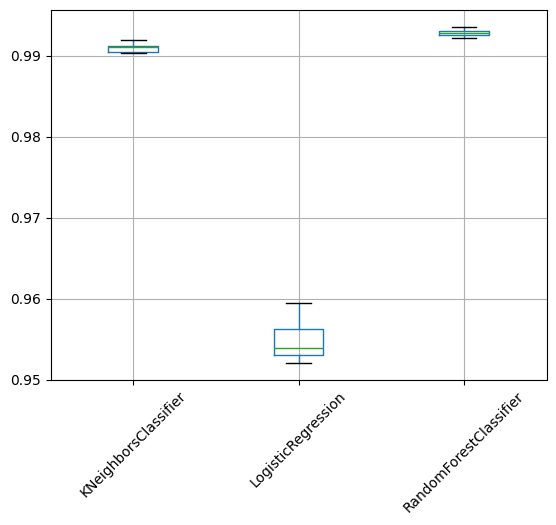

In [17]:
# a box plot will do well to show us overall performance and the variation in the models.
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

In [18]:
# a helper function for getting some analytical data about our predictions
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    # we need to add the predicted and actual outcomes to the data
    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'],
                                   original_data['predicted'])

    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]

    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # idetify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}

    return prediction_data

<Axes: >

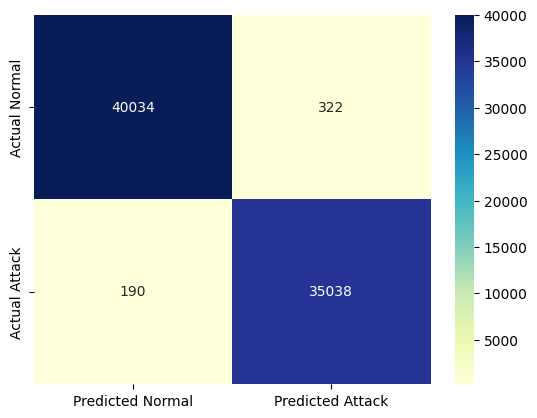

In [19]:
# capture our prediction data
binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [21]:
# Cell 4 (Updated): Save the trained model locally after training
from sklearn.ensemble import RandomForestClassifier
import joblib
import pandas as pd

# Lists to hold our attack classifications
dos_attacks = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
U2R = ['buffer_overflow', 'loadmdoule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
Sybil = ['ftp_write', 'guess_passwd', 'http_tunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xclock', 'xsnoop']

# Helper function to map attack labels
def map_attack(attack):
    if attack in dos_attacks:
        attack_type = 'DoS'
    elif attack in probe_attacks:
        attack_type = 'Probe'
    elif attack in U2R:
        attack_type = 'U2R'
    elif attack in Sybil:
        attack_type = 'Sybil'
    else:
        attack_type = 'Normal'
    return attack_type

# Model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)

# Save the trained model to a file
model_path = 'binary_model.pkl'
joblib.dump(binary_model, model_path)
print(f"Model saved to {model_path}")

# Predict and evaluate
binary_predictions = binary_model.predict(binary_val_X)

# Map predictions to attack labels
binary_prediction_labels = ["Attack" if pred == 1 else "No Attack" for pred in binary_predictions]

# Add predictions as a new column to the validation dataset
binary_val_dataset = binary_val_X.copy()
binary_val_dataset['Prediction'] = binary_prediction_labels

# Add mapped attack types if available
if 'attack' in binary_val_dataset.columns:
    binary_val_dataset['Mapped_Attack'] = binary_val_dataset['attack'].apply(map_attack)

# Print the dataset with predictions
print("Validation Dataset with Predictions:")
print(binary_val_dataset.head())

# Calculate and display base accuracy
from sklearn.metrics import accuracy_score
base_rf_score = accuracy_score(binary_predictions, binary_val_y)
print(f"Base Accuracy: {base_rf_score}")

# ---- Add this as a new cell ----

# Cell: Load the model and predict
# Load the model from the file
loaded_model = joblib.load(model_path)
print("Model loaded successfully.")

# Make predictions on a new dataset (example: test_set)
new_predictions = loaded_model.predict(test_set)

# Map predictions to attack labels
mapped_predictions = ["Attack" if pred == 1 else "No Attack" for pred in new_predictions]

# Add predictions as a new column to the test dataset
test_dataset_with_predictions = test_set.copy()
test_dataset_with_predictions['Prediction'] = mapped_predictions

# Add mapped attack types if available
if 'attack' in test_dataset_with_predictions.columns:
    test_dataset_with_predictions['Mapped_Attack'] = test_dataset_with_predictions['attack'].apply(map_attack)

# Print the test dataset with predictions
print("Test Dataset with Predictions:")
print(test_dataset_with_predictions.head())

# ---- Separate prediction code ----

# Separate function for predictions
def predict_with_labels_and_map_attacks(model_path, dataset):
    # Load the model
    loaded_model = joblib.load(model_path)
    print("Model loaded successfully.")

    # Make predictions
    predictions = loaded_model.predict(dataset)

    # Map predictions to attack labels
    prediction_labels = ["Attack" if pred == 1 else "No Attack" for pred in predictions]

    # Add predictions as a new column to the dataset
    dataset_with_predictions = dataset.copy()
    dataset_with_predictions['Prediction'] = prediction_labels

    # Map attack types if available
    if 'attack' in dataset.columns:
        dataset_with_predictions['Mapped_Attack'] = dataset['attack'].apply(map_attack)

    return dataset_with_predictions

# Example usage
# test_dataset_with_predictions = predict_with_labels_and_map_attacks('binary_model.pkl', test_set)
# print("Dataset with Predictions and Mapped Attacks:")
# print(test_dataset_with_predictions.head())


Model saved to binary_model.pkl
Validation Dataset with Predictions:
       protocol_type_icmp  protocol_type_tcp  protocol_type_udp  service_IRC  \
7684                False               True              False        False   
70897               False               True              False        False   
9824                False               True              False        False   
59158               False               True              False        False   
13762               False               True              False        False   

       service_X11  service_Z39_50  service_aol  service_auth  service_bgp  \
7684         False           False        False         False        False   
70897        False           False        False         False        False   
9824         False           False        False         False        False   
59158        False           False        False         False        False   
13762        False            True        False         Fals